In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm
import skimage.io
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Instantiating the model for loading the weights and biases and preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input

%matplotlib inline

In [2]:
# Reading Data

train_dataset_0_all = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

#test_dataset  = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/*.bmp')
#valid_dataset = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/*.bmp')

valid_data    = pd.read_csv('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [3]:
A = []
H = []

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

A = np.array(A)
H = np.array(H)

len(A),len(H)

(7272, 3389)

In [4]:
Image = []
Label = []

for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

100%|██████████| 3389/3389 [09:32<00:00,  5.92it/s]


((10661, 128, 128, 3), (10661,))

In [5]:
# Shuffle the data as results are appened.

Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 61.24it/s]


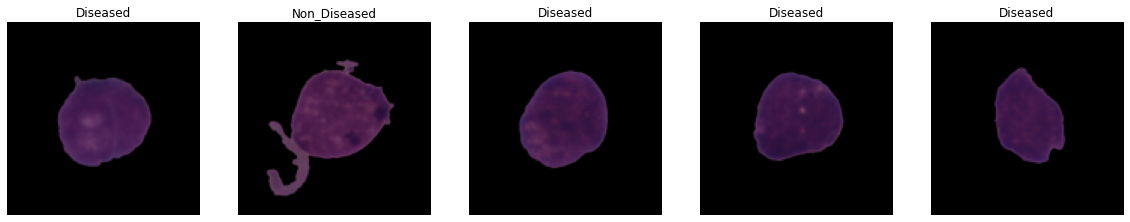

In [6]:
# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [7]:
# Assigning Images and Label to new variable 

X = Image
y = Label

In [8]:
del Image 
del Label
del A
del H

In [9]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [10]:
# Checking target coloumn distribution

valid_data.labels.value_counts()

1    1219
0     648
Name: labels, dtype: int64

In [11]:
# Loading image and storing it numpy array.

X_val = []

for image_name in valid_data.new_names:
    # Loading images
    img = imread('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing 
    img = resize(img, (128,128))
    # Appending them into list
    X_val.append(img)
 
# Converting into array
X_val = np.array(X_val)

# Storing target values as well 
y_val = valid_data.labels.values

In [12]:
# Augmentation & Applying preprocessing function of pre-trained model.

train_datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range = 0.2,
                                    preprocessing_function=preprocess_input)
train_datagen.fit(X)

In [13]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen.fit(X_val)

In [14]:
# Creating model 

xcep = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))

In [15]:
# Model Summary 

xcep.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [16]:
# We dont want to train all layers so, we do following step because we are using same weights given in VGG16

for layers in xcep.layers:
    layers.trainable = False

In [17]:
# Introducing Flatten Layer

x = Flatten()(xcep.output)

In [18]:
# Introducing FCC & Output Layer

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

In [19]:
# Creating Final Model

model = Model(inputs = xcep.input, outputs = final_layer)

In [20]:
# Summary

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [21]:
# Model Compile 

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [22]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)

callback_list = [earlystopping, checkpoint, learning_rate]

In [ ]:
# Fitting Model

model_history = model.fit(train_datagen.flow(X, y, batch_size=512), 
                          validation_data = (X_val, y_val),
                          epochs = 5,
                          verbose = 1,
                          callbacks = callback_list)